# Using the RNN to predict vending machine sales

In [46]:
import pandas as pd
import numpy as np
import datetime
import torch
import math
from torch import nn
from typing import Optional
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]

In [57]:
# Loading the dataset. This dataset is based on the real snack vending machine sales, all private data was removed

df = pd.read_csv('snack_machine_sales_dataset.csv', delimiter=',', parse_dates=['datetime'])

df

,Unnamed: 0,datetime,currency,price,product
0,0,2022-01-10 18:19:46,EUR,3.0,Hamburger
1,1,2022-01-10 17:29:39,EUR,3.0,Hamburger
2,2,2022-01-10 17:29:27,EUR,3.0,Hamburger
3,3,2022-01-10 16:48:37,EUR,3.0,Hamburger
4,4,2022-01-10 16:39:52,EUR,3.0,Hamburger
...,...,...,...,...,...
8193,8193,2021-02-15 14:23:13,EUR,3.0,Hamburger
8194,8194,2021-02-15 13:06:33,EUR,3.0,Hamburger
8195,8195,2021-02-15 12:48:33,EUR,3.0,Hamburger
8196,8196,2021-02-15 12:48:21,EUR,3.0,Hamburger


In [58]:
# Date and time helpers

def to_date(dt: datetime) -> datetime.date:
    return dt.date()


def to_date_hour(dt: datetime.datetime) -> datetime.date:
    # Return date+hour without minutes and seconds
    return dt.replace(minute=0, second=0, microsecond=0)


def to_hour(dt: datetime) -> int:
    return dt.hour


def to_dayofweek(dt: datetime.datetime) -> int:
    return dt.date().weekday()  # Monday == 0 ... Sunday == 6


def to_holiday(dt: datetime.datetime) -> int:
    return int(to_dayofweek(dt) == 5 or to_dayofweek(dt) == 6)


def get_diff_hours(d1: datetime.datetime, d2: datetime.datetime) -> int:
    diff = d2 - d1
    return (24*60*60*diff.days + diff.seconds) // 3600

In [59]:
# Let's add date and hour columns to the dataset 

df['date'] = df['datetime'].map(to_date, na_action=None)
df['date+hour'] = df['datetime'].map(to_date_hour, na_action=None)

df

,Unnamed: 0,datetime,currency,price,product,date,date+hour
0,0,2022-01-10 18:19:46,EUR,3.0,Hamburger,2022-01-10,2022-01-10 18:00:00
1,1,2022-01-10 17:29:39,EUR,3.0,Hamburger,2022-01-10,2022-01-10 17:00:00
2,2,2022-01-10 17:29:27,EUR,3.0,Hamburger,2022-01-10,2022-01-10 17:00:00
3,3,2022-01-10 16:48:37,EUR,3.0,Hamburger,2022-01-10,2022-01-10 16:00:00
4,4,2022-01-10 16:39:52,EUR,3.0,Hamburger,2022-01-10,2022-01-10 16:00:00
...,...,...,...,...,...,...,...
8193,8193,2021-02-15 14:23:13,EUR,3.0,Hamburger,2021-02-15,2021-02-15 14:00:00
8194,8194,2021-02-15 13:06:33,EUR,3.0,Hamburger,2021-02-15,2021-02-15 13:00:00
8195,8195,2021-02-15 12:48:33,EUR,3.0,Hamburger,2021-02-15,2021-02-15 12:00:00
8196,8196,2021-02-15 12:48:21,EUR,3.0,Hamburger,2021-02-15,2021-02-15 12:00:00


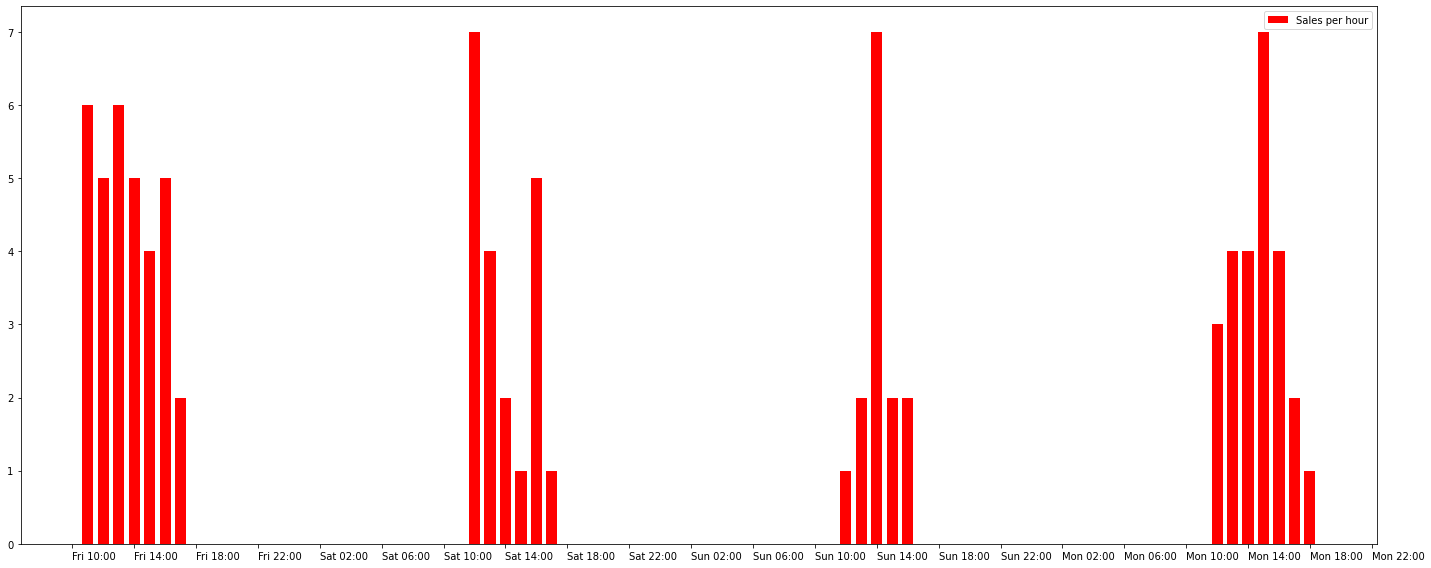

In [60]:
# Let's group the sales per hour and see how the data looks. I draw several days only, because of the screen size

start_date = (df['date+hour'].max() - pd.DateOffset(days=3)).replace(hour=0, minute=0, second=0, microsecond=0)
df_last_days = df[(df['date+hour'] >= start_date)]
gr_revenue = df_last_days.groupby(['date+hour'], as_index=False).size()
revenue_dates, revenue_values = gr_revenue['date+hour'].tolist(), gr_revenue['size'].values

fig = plt.figure()
plt.bar(revenue_dates, revenue_values, width=0.03, color='red', label="Sales per hour")
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
for tick in plt.gca().xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
plt.legend(loc="upper right")
fig.tight_layout()
plt.show()  

In [75]:
# We will use sales data from the last month only

last_months = 1
start_date = (df['date+hour'].max() - pd.DateOffset(months=last_months)).replace(hour=0, minute=0, second=0, microsecond=0)
df_month = df[(df['date+hour'] >= start_date)]

# Group the sales per day and hour

gr_revenue = df_month.groupby(['date+hour'], as_index=False).size()
revenue_dates, revenue_values = gr_revenue['date+hour'].tolist(), gr_revenue['size'].values

# Lets prepare data for the neural network. Not every hour had a sales, let's make the sequence 'monotonous' and fill sales per hour for each hour from 00 to 23. Missing hours will be filled with zeros.

data = []
# If the first sales at the first day does not start at 0:00, add zero values to the missing hours
day_start = revenue_dates[0].replace(hour=0, minute=0, second=0, microsecond=0)
for hr in range(revenue_dates[0].hour):
    data.append([day_start + datetime.timedelta(hours=hr), 0])
# Add other values and fill gaps between hours if needed
for idx in range(len(revenue_dates) - 1):
    d1, d2, rev1 = revenue_dates[idx], revenue_dates[idx + 1], revenue_values[idx]
    data.append([d1, rev1])
    # Add current value and zero values for each hour between d1 and d2
    diff_hr =  get_diff_hours(d1, d2)
    for hr in range(1, diff_hr):
        data.append([d1 + datetime.timedelta(hours=hr), 0])
# if the last sale did not happen at 23:59, add zero values to the missing hours
for hr in range(revenue_dates[-1].hour + 1, 24):
    data.append([revenue_dates[-1] + datetime.timedelta(hours=hr - revenue_dates[-1].hour), 0])

# Prepare dates-based dataframe

df_data = pd.DataFrame(data, columns=['datetime', 'value'])
df_data = df_data.set_index(['datetime'])

df_data[:24]

,value
datetime,
2021-12-10 00:00:00,0
2021-12-10 01:00:00,0
2021-12-10 02:00:00,0
2021-12-10 03:00:00,0
2021-12-10 04:00:00,0
2021-12-10 05:00:00,0
2021-12-10 06:00:00,0
2021-12-10 07:00:00,0
2021-12-10 08:00:00,0


In [86]:
# Time for fun :) 
# Let's prepare data for the neural network. Days of week and hours are cyclical, we will represent it as sine and cosine values. 
# I also added the "is_holiday" column because sales are dependent on the fact is the day is holiday or not.
# Sales values will be also normalized.


def make_cyclical_sin(value, period) -> float:
    return math.sin(2*np.pi*value/period)


def make_cyclical_cos(value, period) -> float:
    return math.cos(2*np.pi*value/period)


def normalize_value(value, v_max) -> float:
    return value/v_max


val_max = df_data["value"].max()
date_start = df_data.index[0]

df_data['is_holiday'] = df_data.index.map(to_holiday, na_action=None)
df_data['value'] = df_data['value'].map(lambda val: normalize_value(val, v_max=val_max))
df_data['hour'] = df_data.index.map(to_hour, na_action=None)
df_data['hour_sin'] = df_data['hour'].map(lambda x: make_cyclical_sin(x, period=24))
df_data['hour_cos'] = df_data['hour'].map(lambda x: make_cyclical_cos(x, period=24))
df_data.drop('hour', axis=1, inplace=True)
df_data['dayofweek'] = df_data.index.map(to_dayofweek, na_action=None)
df_data['dayofweek_sin'] = df_data['dayofweek'].map(lambda x: make_cyclical_sin(x, period=7))
df_data['dayofweek_cos'] = df_data['dayofweek'].map(lambda x: make_cyclical_cos(x, period=7))
df_data.drop('dayofweek', axis=1, inplace=True)

df_data[:24]

,value,is_holiday,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,,
2021-12-10 00:00:00,0.000000,0,0.000000e+00,1.000000e+00,-0.433884,-0.900969
2021-12-10 01:00:00,0.000000,0,2.588190e-01,9.659258e-01,-0.433884,-0.900969
2021-12-10 02:00:00,0.000000,0,5.000000e-01,8.660254e-01,-0.433884,-0.900969
2021-12-10 03:00:00,0.000000,0,7.071068e-01,7.071068e-01,-0.433884,-0.900969
2021-12-10 04:00:00,0.000000,0,8.660254e-01,5.000000e-01,-0.433884,-0.900969
2021-12-10 05:00:00,0.000000,0,9.659258e-01,2.588190e-01,-0.433884,-0.900969
2021-12-10 06:00:00,0.000000,0,1.000000e+00,6.123234e-17,-0.433884,-0.900969
2021-12-10 07:00:00,0.000000,0,9.659258e-01,-2.588190e-01,-0.433884,-0.900969
2021-12-10 08:00:00,0.000000,0,8.660254e-01,-5.000000e-01,-0.433884,-0.900969


In [94]:
# Create the neural network model

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.n_layers = 1
        self.input_dim = input_dim
        self.hidden_dim = 20
        self.lstm1 = nn.LSTMCell(self.input_dim, self.hidden_dim)  # 1 feature in input, 51 in hidden_state
        self.lstm2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.linear = nn.Linear(self.hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.double()  # Use double instead of float

    def forward(self, input, d_start: Optional[datetime.datetime]=None, future=0):
        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.double)
        output = None
        h_t, c_t = self.lstm1(input, (h_t, c_t))
        h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
        output = self.linear(h_t2)  # output.shape: [446, 1]
        output = self.sigmoid(output)
        outputs += [output]
        outputs = torch.cat(outputs, dim=0)
        return outputs

In [95]:
# Prepare data for the model training. For simplicity reasons I don't prepare a validation dataset


def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y


# X_train - source values, y_train - amount of sales normalized to 0..1

X_train, y_train = feature_label_split(df_data, target_col='value')
input_count, input_size = X_train.shape

print(f"Input data size: {input_count}x{input_size}")

Input data size: 767x5


In [96]:
X_train

,is_holiday,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,
2021-12-10 00:00:00,0,0.000000,1.000000,-0.433884,-0.900969
2021-12-10 01:00:00,0,0.258819,0.965926,-0.433884,-0.900969
2021-12-10 02:00:00,0,0.500000,0.866025,-0.433884,-0.900969
2021-12-10 03:00:00,0,0.707107,0.707107,-0.433884,-0.900969
2021-12-10 04:00:00,0,0.866025,0.500000,-0.433884,-0.900969
...,...,...,...,...,...
2022-01-10 19:00:00,0,-0.965926,0.258819,0.000000,1.000000
2022-01-10 20:00:00,0,-0.866025,0.500000,0.000000,1.000000
2022-01-10 21:00:00,0,-0.707107,0.707107,0.000000,1.000000


In [97]:
y_train

,value
datetime,
2021-12-10 00:00:00,0.0
2021-12-10 01:00:00,0.0
2021-12-10 02:00:00,0.0
2021-12-10 03:00:00,0.0
2021-12-10 04:00:00,0.0
...,...
2022-01-10 19:00:00,0.0
2022-01-10 20:00:00,0.0
2022-01-10 21:00:00,0.0


In [98]:
# Convert data to the Pytorch format

X_train = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1]))
y_train = y_train.to_numpy().reshape((y_train.shape[0], y_train.shape[1]))
input = torch.from_numpy(X_train)
target = torch.from_numpy(y_train)

In [129]:
# Create and train the model

def get_trained_model(train_steps: int):
    model = Model(input_dim=input_size)
    criterion = nn.MSELoss(reduction="mean")
    optimizer = optim.LBFGS(model.parameters(), lr=0.1)
    model.train()  # Set train mode
    model.train_steps = train_steps
    for i in range(train_steps):
        print(f"Training: Step {i+1} of {train_steps}")

        def closure():
            optimizer.zero_grad()
            out = model(input)
            loss = criterion(out, target)
            loss.backward()
            return loss

        optimizer.step(closure)
    return model

In [130]:
# Let's compare training results for 1, 2 and 10 steps

model1 = get_trained_model(train_steps=1)

Training: Step 1 of 1


In [131]:
model2 = get_trained_model(train_steps=2)

Training: Step 1 of 2
Training: Step 2 of 2


In [132]:
model3 = get_trained_model(train_steps=10)

Training: Step 1 of 10
Training: Step 2 of 10
Training: Step 3 of 10
Training: Step 4 of 10
Training: Step 5 of 10
Training: Step 6 of 10
Training: Step 7 of 10
Training: Step 8 of 10
Training: Step 9 of 10
Training: Step 10 of 10


In [138]:
# Let's make a data blob that we will use for prediction. Because of the screen size, I will generate sales values only for 14 days

dates = []
data_in = []
predict_hours_num = 14*24
for hr in range(predict_hours_num):
    dt = date_start + datetime.timedelta(hours=hr)
    data_in.append((to_holiday(dt), make_cyclical_sin(to_hour(dt), period=24), make_cyclical_cos(to_hour(dt), period=24),
                                    make_cyclical_sin(to_dayofweek(dt), period=7), make_cyclical_cos(to_dayofweek(dt), period=7)))
    dates.append(dt)
data_in = pd.DataFrame(data_in, columns=['is_holiday', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos'])
data_in = torch.from_numpy(data_in.to_numpy())

In [139]:
# Data predict

with torch.no_grad():
    pred1 = model1(data_in)
    y1 = pred1.view(-1)
    
    pred2 = model2(data_in)
    y2 = pred2.view(-1)
    
    pred3 = model3(data_in)
    y3 = pred3.view(-1)

In [144]:
# Draw helper

def data_draw(data_orig, data_pred, train_steps):
    fig = plt.figure()
    plt.bar(dates[:len(data_orig)], data_orig, width=0.04, color='green', label="original")
    plt.bar(dates, data_pred, width=0.03, color='red', label="predicted")
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %d-%m-%Y'))
    plt.gca().set_ylim([0, 1.1*val_max])
    for tick in plt.gca().xaxis.get_majorticklabels():
        tick.set_horizontalalignment("left")
    plt.legend(loc="upper right")
    plt.title("LSTM %d steps training" % train_steps)
    fig.tight_layout()
    plt.show()  

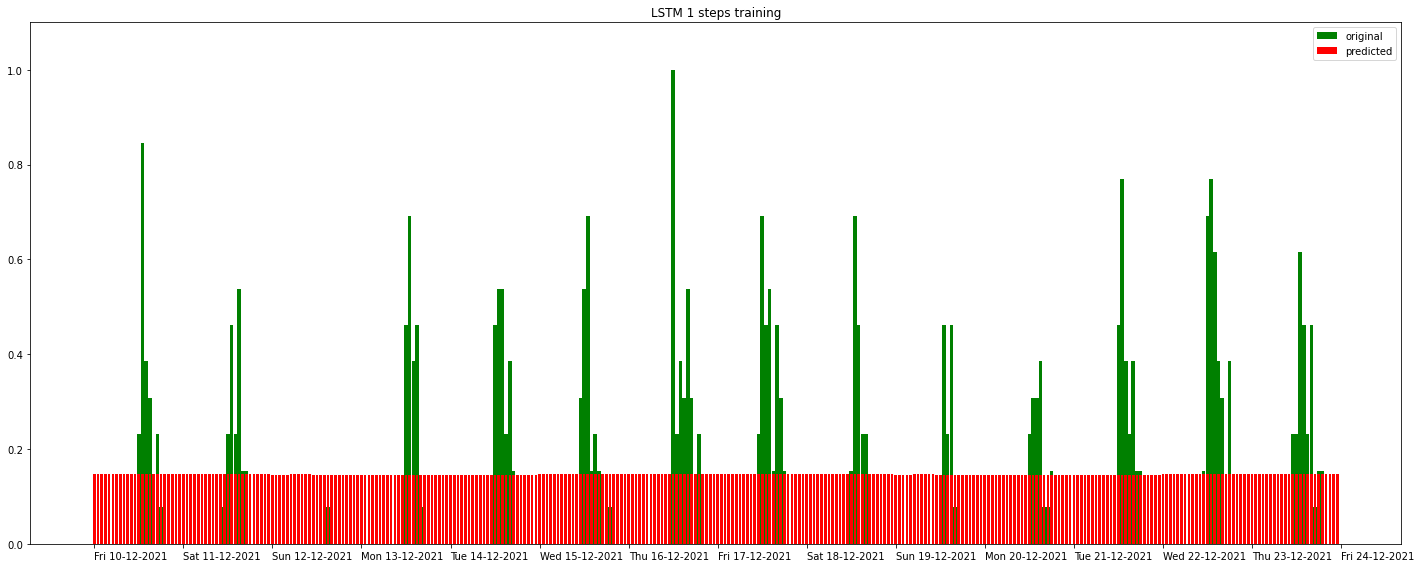

In [145]:
# RNN 1 Steps training

data_orig = target.detach().reshape(-1)[:predict_hours_num].numpy()*val_max
data_pred1 = y1.detach().numpy()*val_max
data_draw(data_orig, data_pred1, model1.train_steps)

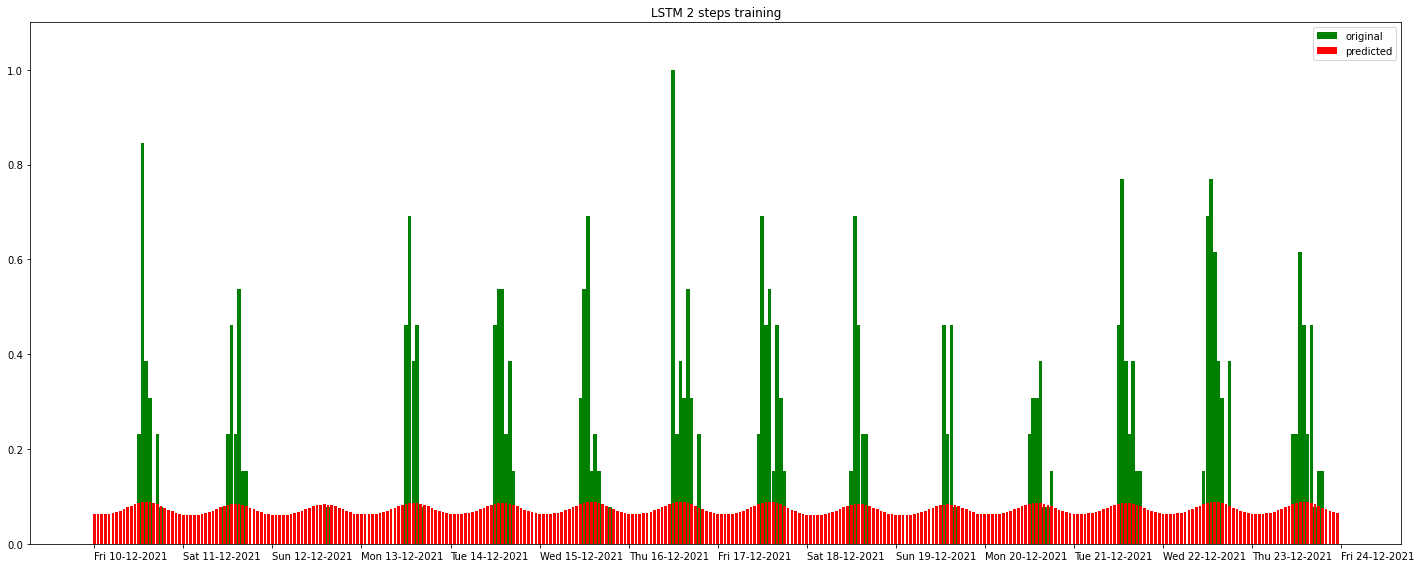

In [146]:
# RNN 2 Steps training

data_orig = target.detach().reshape(-1)[:predict_hours_num].numpy()*val_max
data_pred2 = y2.detach().numpy()*val_max
data_draw(data_orig, data_pred2, model2.train_steps)

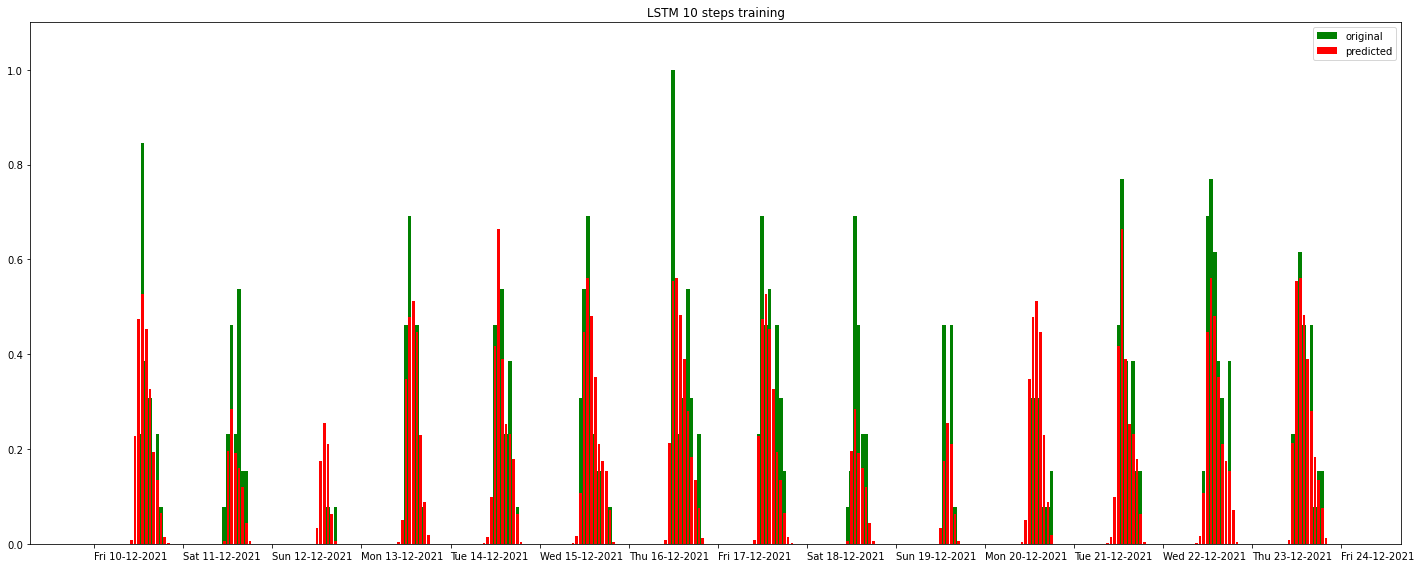

In [147]:
# RNN 10 Steps training

data_orig = target.detach().reshape(-1)[:predict_hours_num].numpy()*val_max
data_pred3 = y3.detach().numpy()*val_max
data_draw(data_orig, data_pred3, model3.train_steps)